## Bad Domains: Visits to Malware/Phishing Sites by Age, Education, and Race

We pair passively observed domain level browsing data from comScore with [pydomains](https://github.com/themains/pydomains), a Python package that provides multiple ways to infer the kind of content hosted by a domain, to examine if the old, the less well educated, and minorities more frequently visit (spend more time) on websites implicated in distributing malware or engaged in phishing than their complementary groups.

Two caveats. The browsing data is at the machine level. And the demographics data is at the household level.

Topline: The most educated most frequently visit (spend most time on) phishing/malware websites. Part of the reason is because they are online more often. When we split the entire sample by race, Asians and Whites more frequently visit (spend more time on) malware/phishing websites than other racial groups. Again, it seems part of the reason is that Asians/Whites spend more time online. When we split by age, we see that the older people more frequently visit (spend most time on) phishing/malware sites. Here there is some evidence that it is because they are choosing worse than younger people.

In [1]:
# import the necessary libraries 
%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

import pandas as pd
import gc

# set aesthetics
sns.set_style("whitegrid")

### Load browsing data for 2016 grouped by domain and machine ID

In [2]:
YEAR = 2016
gdf = pd.read_csv('/opt/data/comscore/pydomains/app2/cs%04d_grp_machine_domain.csv.bz2' % YEAR)
gdf.head()

,machine_id,domain_name,total_time,total_visits
0,17549714,100dayloans.com,0,1
1,17549714,1fbusa.com,43,18
2,17549714,2020panel.com,91,22
3,17549714,247-inc.net,46,32
4,17549714,4salelocal.net,1,1


How many machines do we have the data from?

In [3]:
len(gdf.machine_id.unique())

81407

### Get the Kind of Content Hosted by a Domain

We use [pydomains](https://github.com/themains/pydomains) to get the kind of content hosted by each of the domains in comScore. (We make the data freely available [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DXSNFA).) We only load the relevant columns: predictions about whether a domain is engaged in phishing from an LSTM model based on PhishTank data and predictions about whether a domain distributes malware from an LSTM model based on Toulouse data and from an LSTM model based on Malware data.

In [4]:
pydom_df = pd.read_csv('/opt/data/comscore/pydomains/cs%04d_unique_domains_pydomains.csv.bz2' % YEAR, usecols=['domain_names', 'pred_phish_2017_prob', 'pred_toulouse_2017_prob_malware', 'pred_malware_2017_prob'])
# rename column
pydom_df.rename(columns={'domain_names': 'domain_name'}, inplace=True)
pydom_df.head()

,domain_name,pred_phish_2017_prob,pred_malware_2017_prob,pred_toulouse_2017_prob_malware
0,realmadridvsbarcelonalivestream.com,0.999508,0.907737,0.065995
1,smartphonerankings.com,0.787181,0.252708,0.004863
2,sdale.org,0.039262,0.007850,0.009953
3,twentyfoursevenrp.com,0.911047,0.979689,0.018030
4,beachhousepublishing.com,0.818236,0.579768,0.008558


In [5]:
# Left join
pdf = gdf.merge(pydom_df, how='left', on='domain_name')
pdf.head()

,machine_id,domain_name,total_time,total_visits,pred_phish_2017_prob,pred_malware_2017_prob,pred_toulouse_2017_prob_malware
0,17549714,100dayloans.com,0,1,0.608718,0.130488,0.012926
1,17549714,1fbusa.com,43,18,0.093295,0.148021,0.025634
2,17549714,2020panel.com,91,22,0.030941,0.041042,0.009577
3,17549714,247-inc.net,46,32,0.172064,0.112687,0.022789
4,17549714,4salelocal.net,1,1,0.202896,0.782387,0.016723


In [6]:
pdf.columns

Index(['machine_id', 'domain_name', 'total_time', 'total_visits',
       'pred_phish_2017_prob', 'pred_malware_2017_prob',
       'pred_toulouse_2017_prob_malware'],
      dtype='object')

In [7]:
# Delete to keep the memory from filling up
%xdel gdf
gc.collect()

60

### Phishing Model

For across race, age, and education inferences to hold, measurement error should be orthogonal to race, income, and education.

In [8]:
pdf['total_time_phishing'] = pdf['pred_phish_2017_prob'] * pdf['total_time']
pdf['total_visits_phishing'] = pdf['pred_phish_2017_prob'] * pdf['total_visits']

### Malware Model

Same caveat as above

In [9]:
pdf['total_time_malware'] = pdf['pred_malware_2017_prob'] * pdf['total_time']
pdf['total_visits_malware'] = pdf['pred_malware_2017_prob'] * pdf['total_visits']

### Toulouse Model (for malware only)

Since we have two measures of Malware, for comparison, for Toulouse, we just use the label.

In [10]:
#pdf['total_time_tl_phishing'] = pdf['pred_toulouse_2017_prob_phishing']* pdf['total_time']
#pdf['total_visits_tl_phishing'] = pdf['pred_toulouse_2017_prob_phishing']* pdf['total_visits']

pdf['total_time_tl_malware'] = pdf['pred_toulouse_2017_prob_malware'] * pdf['total_time']
pdf['total_visits_tl_malware'] = pdf['pred_toulouse_2017_prob_malware'] * pdf['total_visits']

pdf.head()

,machine_id,domain_name,total_time,total_visits,pred_phish_2017_prob,pred_malware_2017_prob,pred_toulouse_2017_prob_malware,total_time_phishing,total_visits_phishing,total_time_malware,total_visits_malware,total_time_tl_malware,total_visits_tl_malware
0,17549714,100dayloans.com,0,1,0.608718,0.130488,0.012926,0.000000,0.608718,0.000000,0.130488,0.000000,0.012926
1,17549714,1fbusa.com,43,18,0.093295,0.148021,0.025634,4.011689,1.679312,6.364887,2.664371,1.102276,0.461418
2,17549714,2020panel.com,91,22,0.030941,0.041042,0.009577,2.815621,0.680700,3.734866,0.902935,0.871481,0.210688
3,17549714,247-inc.net,46,32,0.172064,0.112687,0.022789,7.914924,5.506034,5.183611,3.605990,1.048310,0.729259
4,17549714,4salelocal.net,1,1,0.202896,0.782387,0.016723,0.202896,0.202896,0.782387,0.782387,0.016723,0.016723


Our final dataset is at the machine_id level. We want to know how much time, how many visits, what proportion of time, and what proportion of visits for each person spent on websites implicated in phishing and distributing malware. 

We start by filtering the data to keep only phishing and malware domains (for each measure). And then simply groupby machine_id. 

In [11]:
cats = ['phishing', 'malware', 'tl_malware']
aggs = {'total_time': sum, 'total_visits': sum}
for c in cats:
    aggs['total_time_{0:s}'.format(c)] = sum
    aggs['total_visits_{0:s}'.format(c)] = sum
gdf = pdf.groupby(['machine_id']).agg(aggs)
gdf.head()

,total_time,total_visits,total_time_phishing,total_visits_phishing,total_time_malware,total_visits_malware,total_time_tl_malware,total_visits_tl_malware
machine_id,,,,,,,,
17549714,36193,4147,7707.853361,999.141693,5495.432937,629.030801,697.654959,63.880703
66614909,8240,1540,993.097239,276.081771,572.591542,162.889070,182.696737,24.294017
66859433,138,9,18.703637,1.890376,4.687678,0.773177,6.711733,0.200808
69370447,1810,105,237.190307,21.306237,74.130916,7.105947,11.387083,1.418917
70605319,3099,288,366.957849,49.022182,186.569234,30.742320,47.281493,4.877688


### Load household level demographics data

In [12]:
dem_df = pd.read_csv('/opt/data/comscore/demographics_by_machine_id/demographics2016.csv', usecols = ['machine_id', 'racial_background', 'country_of_origin', 'hoh_oldest_age', 'hoh_most_education'])
dem_df.describe()

,machine_id,hoh_most_education,hoh_oldest_age,racial_background,country_of_origin
count,8.141700e+04,81417.000000,81417.000000,81417.000000,81417.000000
mean,1.824559e+08,37.414508,7.233919,2.162509,0.115676
std,1.349811e+07,46.215620,2.783556,1.916148,0.319838
min,1.754971e+07,1.000000,1.000000,-88.000000,0.000000
25%,1.731818e+08,2.000000,5.000000,1.000000,0.000000
50%,1.854283e+08,4.000000,8.000000,1.000000,0.000000
75%,1.933604e+08,99.000000,9.000000,3.000000,0.000000
max,2.011002e+08,99.000000,99.000000,5.000000,1.000000


### Convert Demographic Codes to Semantic Labels

Let's translate numerical labels to semantic labels

In [13]:
race = {1: 'White', 
        2: 'Black', 
        3: 'Asian', 
        5: 'Other',
        -88: 'Missing'}

dem_df['racial_background'] = dem_df['racial_background'].replace(race)
(dem_df['racial_background'].value_counts()/dem_df['racial_background'].value_counts().sum()).round(2)

White      0.58
Other      0.23
Black      0.12
Asian      0.07
Missing    0.00
Name: racial_background, dtype: float64

In [14]:
dem_df['country_of_origin'] = dem_df['country_of_origin'].replace({0: 'Non-Hispanic', 
                                                                   1: 'Hispanic'})
(dem_df['country_of_origin'].value_counts()/dem_df['country_of_origin'].value_counts().sum()).round(2)

Non-Hispanic    0.88
Hispanic        0.12
Name: country_of_origin, dtype: float64

In [15]:
age = {1: '18-20', 
       2: '21-24',
       3: '25-29', 
       4: '30-34',
       5: '35-39',
       6: '40-44',
       7: '45-49',
       8: '50-54',
       9: '55-59',
       10: '60-64',
       11: '65 and over',
       99: 'Missing'}

dem_df['hoh_oldest_age'] = dem_df['hoh_oldest_age'].replace(age)
(dem_df['hoh_oldest_age'].value_counts()/dem_df['hoh_oldest_age'].value_counts().sum()).round(2)

65 and over    0.15
50-54          0.15
45-49          0.13
55-59          0.11
40-44          0.10
35-39          0.08
60-64          0.08
30-34          0.07
25-29          0.06
21-24          0.03
18-20          0.02
Missing        0.00
Name: hoh_oldest_age, dtype: float64

In [16]:
edu = {0: 'Less than a high school diploma',
       1: 'High school diploma or equivalent', 
       2: 'Some college but no degree', 
       3: 'Associate degree', 
       4: 'Bachelor’s degree',
       5: 'Graduate degree',
       99: 'Missing'}

dem_df['hoh_most_education'] = dem_df['hoh_most_education'].replace(edu)
(dem_df['hoh_most_education'].value_counts()/dem_df['hoh_most_education'].value_counts().sum()).round(2)

Missing                              0.36
Some college but no degree           0.26
Associate degree                     0.21
Bachelor’s degree                    0.14
High school diploma or equivalent    0.03
Graduate degree                      0.01
Name: hoh_most_education, dtype: float64

## Merge browsing data with demographics data

In [17]:
mdf = gdf.merge(dem_df, how='left', on='machine_id')

In [18]:
# Given the data are pretty big, we delete gdf and call the garbage collector
%xdel gdf
gc.collect()

20

In [19]:
mdf.head()

,machine_id,total_time,total_visits,total_time_phishing,total_visits_phishing,total_time_malware,total_visits_malware,total_time_tl_malware,total_visits_tl_malware,hoh_most_education,hoh_oldest_age,racial_background,country_of_origin
0,17549714,36193,4147,7707.853361,999.141693,5495.432937,629.030801,697.654959,63.880703,Missing,40-44,White,Non-Hispanic
1,66614909,8240,1540,993.097239,276.081771,572.591542,162.889070,182.696737,24.294017,Some college but no degree,60-64,White,Hispanic
2,66859433,138,9,18.703637,1.890376,4.687678,0.773177,6.711733,0.200808,Missing,25-29,White,Non-Hispanic
3,69370447,1810,105,237.190307,21.306237,74.130916,7.105947,11.387083,1.418917,Missing,55-59,Other,Non-Hispanic
4,70605319,3099,288,366.957849,49.022182,186.569234,30.742320,47.281493,4.877688,Missing,21-24,Other,Non-Hispanic


In [20]:
mdf.describe().astype(int)

,machine_id,total_time,total_visits,total_time_phishing,total_visits_phishing,total_time_malware,total_visits_malware,total_time_tl_malware,total_visits_tl_malware
count,81407,81407,81407,81407,81407,81407,81407,81407,81407
mean,182457976,14915,981,2332,180,1607,115,260,16
std,13496576,29915,1546,7289,350,5968,222,796,26
min,17549714,0,1,0,0,0,0,0,0
25%,173182743,1286,146,169,23,109,14,19,2
50%,185429062,4998,469,667,78,430,49,76,7
75%,193360555,15719,1242,2119,218,1378,138,249,20
max,201100249,1383660,99484,455084,30493,434907,18297,98970,1340


### Analysis

#### By Education

We start by tracking total time spent and total number of visits to phishing and malware sites by education.

In [21]:
abc = mdf.groupby(['hoh_most_education'])['total_time_phishing', 'total_visits_phishing'].describe().astype(int)
abc.to_csv('./bad_educ.csv')
mdf.groupby(['hoh_most_education'])['total_time_phishing', 'total_visits_phishing'].describe().astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


total_time_phishing                       \
                                                count  mean   std min  25%   
hoh_most_education                                                           
Associate degree                                16810  2821  9036   0  336   
Bachelor’s degree                               11342  2977  6680   0  376   
Graduate degree                                   539  3292  6433   0  399   
High school diploma or equivalent                2489  2276  6135   0  249   
Missing                                         29319  1532  5636   0   55   
Some college but no degree                      20908  2691  8092   0  297   

                                                      total_visits_phishing  \
                                    50%   75%     max                 count   
hoh_most_education                                                            
Associate degree                    991  2664  455084                 16810   
Bachelor’s degree                  1146  2996  151887                 11342   
Graduate degree                    1415  3722   88502                   539   
High school diploma or equivalent   759  2168  190064                  2489   
Missing                             265  1075  335871                 29319   
Some college but no degree          898  2538  406021                 20908   

                                                                      
                                  mean  std min 25%  50%  75%    max  
hoh_most_education                                                    
Associate degree                   220  439   0  42  116  275  30493  
Bachelor’s degree                  246  323   0  48  137  318   6925  
Graduate degree                    277  313   0  52  168  399   2228  
High school diploma or equivalent  172  308   0  32   86  211   9378  
Missing                            110  278   0   9   33  110  22199  
Some college but no degree         210  362   0  38  103  257  26028

The first thing that jumps out is the sharp right skew. Given the skew, we focus on the medians. There a slightly surprising pattern emerges: the greater the education level of the most educated person in the household, the more frequent the visits (identified by the median but holds for 75th percentile) to phishing sites. For instance, households where graduate education is the highest level of education visit phishing related sites more often (median = 8) than households where the most educated person just has a bachelor's degree (median = 7). When we look at the time, the pattern is slightly less clear but consistent.

Looking at visits and time spent on malware sites (see below), the pattern is broadly the same. And this is true regardless of what way we measure malware sites---Toulouse or Malware data.

In [22]:
mdf.groupby(['hoh_most_education'])['total_time_malware', 'total_visits_malware'].describe().astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_malware                       \
                                               count  mean   std min  25%   
hoh_most_education                                                          
Associate degree                               16810  1926  7594   0  213   
Bachelor’s degree                              11342  1982  4878   0  239   
Graduate degree                                  539  2176  4426   0  250   
High school diploma or equivalent               2489  1582  4518   0  156   
Missing                                        29319  1053  4356   0   36   
Some college but no degree                     20908  1912  7012   0  191   

                                                     total_visits_malware  \
                                   50%   75%     max                count   
hoh_most_education                                                          
Associate degree                   634  1745  434907                16810   
Bachelor’s degree                  727  1964  150629                11342   
Graduate degree                    886  2374   51478                  539   
High school diploma or equivalent  485  1425  122099                 2489   
Missing                            174   711  245677                29319   
Some college but no degree         576  1679  401863                20908   

                                                                      
                                  mean  std min 25%  50%  75%    max  
hoh_most_education                                                    
Associate degree                   139  271   0  26   73  173  18297  
Bachelor’s degree                  154  205   0  30   85  200   4641  
Graduate degree                    176  205   0  31  104  249   1378  
High school diploma or equivalent  109  198   0  20   54  133   6076  
Missing                             71  178   0   6   21   71  13899  
Some college but no degree         134  233   0  24   65  164  16532

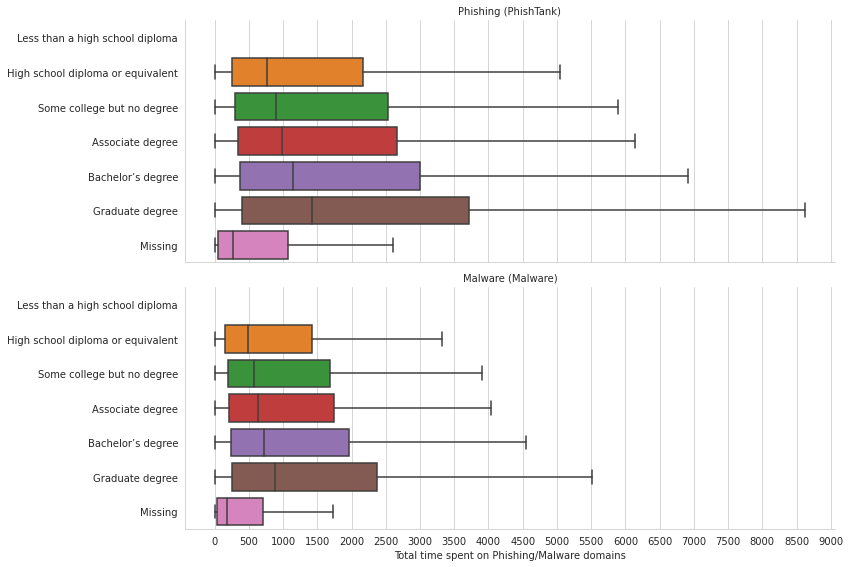

In [23]:
adf = pd.melt(mdf, id_vars=['hoh_most_education'], value_vars=['total_time_phishing', 'total_time_malware'], var_name='model', value_name='total_time')
adf['model'] = adf['model'].replace({'total_time_phishing':'Phishing (PhishTank)', 'total_time_malware':'Malware (Malware)'})

g = sns.catplot(x="total_time", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total time spent on Phishing/Malware domains')


for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_time_phishing_malware_educ.eps', format='eps', dpi=300)

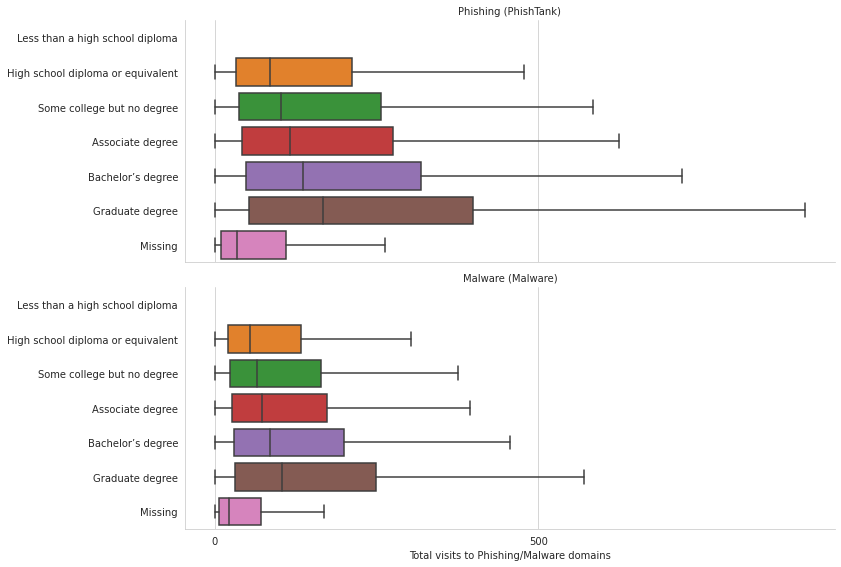

In [48]:
adf = pd.melt(mdf, id_vars=['hoh_most_education'], value_vars=['total_visits_phishing', 'total_visits_malware'], var_name='model', value_name='total_visits')
adf['model'] = adf['model'].replace({'total_visits_phishing':'Phishing (PhishTank)', 'total_visits_malware':'Malware (Malware)'})

g = sns.catplot(x="total_visits", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total visits to Phishing/Malware domains')


for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_visits_phishing_malware_educ.eps', format='eps', dpi=300)

In [24]:
mdf.groupby(['hoh_most_education'])['total_time_tl_malware', 'total_visits_tl_malware'].describe(percentiles = [.25, .5, .75, .85]).astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_tl_malware                    \
                                                  count mean  std min 25%   
hoh_most_education                                                          
Associate degree                                  16810  317  901   0  38   
Bachelor’s degree                                 11342  360  920   0  44   
Graduate degree                                     539  379  587   0  50   
High school diploma or equivalent                  2489  247  498   0  29   
Missing                                           29319  162  570   0   6   
Some college but no degree                        20908  299  917   0  34   

                                                         \
                                   50%  75%  85%    max   
hoh_most_education                                        
Associate degree                   114  321  533  77749   
Bachelor’s degree                  136  379  621  51806   
Graduate degree                    185  449  740   6802   
High school diploma or equivalent   86  252  456  12114   
Missing                             30  119  244  53732   
Some college but no degree         102  298  523  98970   

                                  total_visits_tl_malware                   \
                                                    count mean std min 25%   
hoh_most_education                                                           
Associate degree                                    16810   20  30   0   4   
Bachelor’s degree                                   11342   22  28   0   5   
Graduate degree                                       539   26  32   0   5   
High school diploma or equivalent                    2489   16  24   0   3   
Missing                                             29319   10  21   0   1   
Some college but no degree                          20908   18  26   0   4   

                                                     
                                  50% 75% 85%   max  
hoh_most_education                                   
Associate degree                   11  25  37  1340  
Bachelor’s degree                  13  30  43   527  
Graduate degree                    16  35  50   327  
High school diploma or equivalent   8  19  29   679  
Missing                             3  10  18   870  
Some college but no degree         10  24  36   956

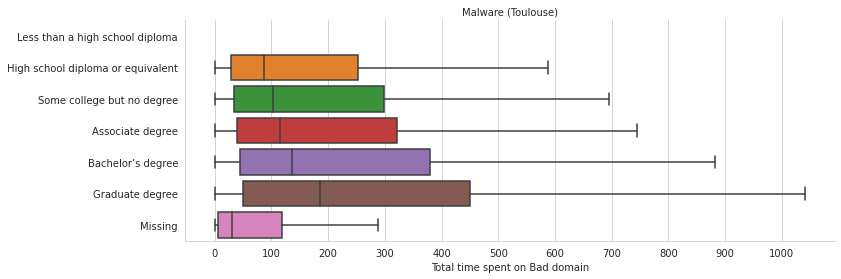

In [25]:
adf = pd.melt(mdf, id_vars=['hoh_most_education'], value_vars=['total_time_tl_malware'], var_name='model', value_name='total_time')
g = sns.catplot(x="total_time", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_ylabels('');
g.set_titles('Malware (Toulouse)');
g.set_xlabels('Total time spent on Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(50))
    
g.savefig('./total_time_tl_malware_educ.eps', format='eps', dpi=300)

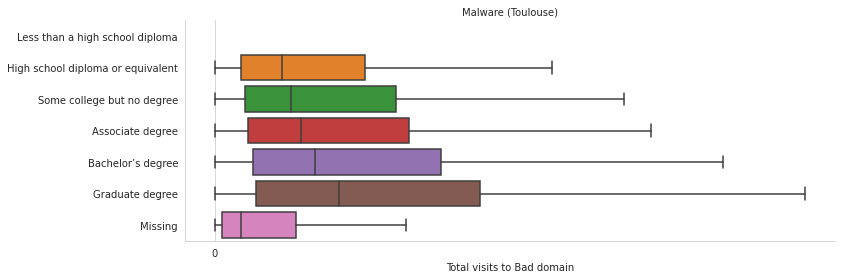

In [49]:
adf = pd.melt(mdf, id_vars=['hoh_most_education'], value_vars=['total_visits_tl_malware'], var_name='model', value_name='total_visits')
g = sns.catplot(x="total_visits", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_ylabels('');
g.set_titles('Malware (Toulouse)');
g.set_xlabels('Total visits to Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(50))
    
g.savefig('./total_visits_tl_malware_educ.eps', format='eps', dpi=300)

#### By Race

Next, we track total time spent and total number of visits to malware sites by racial background. Here we see reasonably consistent results with the following broad pattern: Asians visit phishing and malware sites most frequently followed by whites, blacks, and "others".

In [26]:
mdf.groupby(['racial_background'])['total_time_phishing', 'total_visits_phishing'].describe().astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_phishing                                   \
                                count  mean   std min  25%   50%   75%   
racial_background                                                        
Asian                            5769  2725  6250   0  415  1163  2931   
Black                            9775  1845  4962   0  188   699  1917   
Missing                            10   302   354   0   42   166   449   
Other                           18553  1163  3714   0   72   259   884   
White                           47300  2843  8679   0  238   864  2601   

                          total_visits_phishing                              \
                      max                 count mean  std min 25%  50%  75%   
racial_background                                                             
Asian              199231                  5769  222  288   0  52  129  290   
Black              216238                  9775  162  495   0  24   78  193   
Missing              1120                    10   19   21   0   4   13   27   
Other              151887                 18553   96  211   0  11   32   95   
White              455084                 47300  212  358   0  31  100  263   

                          
                     max  
racial_background         
Asian               5900  
Black              30493  
Missing               71  
Other              10813  
White              26028

In [27]:
mdf.groupby(['racial_background'])['total_time_malware', 'total_visits_malware'].describe().astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_malware                                          \
                               count  mean   std min  25%  50%   75%     max   
racial_background                                                              
Asian                           5769  1810  4970   0  271  742  1891  175442   
Black                           9775  1265  3857   0  121  446  1251  210861   
Missing                           10   174   235   0   28   55   233     756   
Other                          18553   808  3012   0   47  167   574  150629   
White                          47300  1966  7159   0  152  554  1707  434907   

                  total_visits_malware                                    
                                 count mean  std min 25% 50%  75%    max  
racial_background                                                         
Asian                             5769  140  184   0  33  80  181   3615  
Black                             9775  103  303   0  16  50  123  18297  
Missing                             10   12   13   0   3   8   17     43  
Other                            18553   61  134   0   7  20   60   6590  
White                            47300  135  230   0  20  63  167  16532

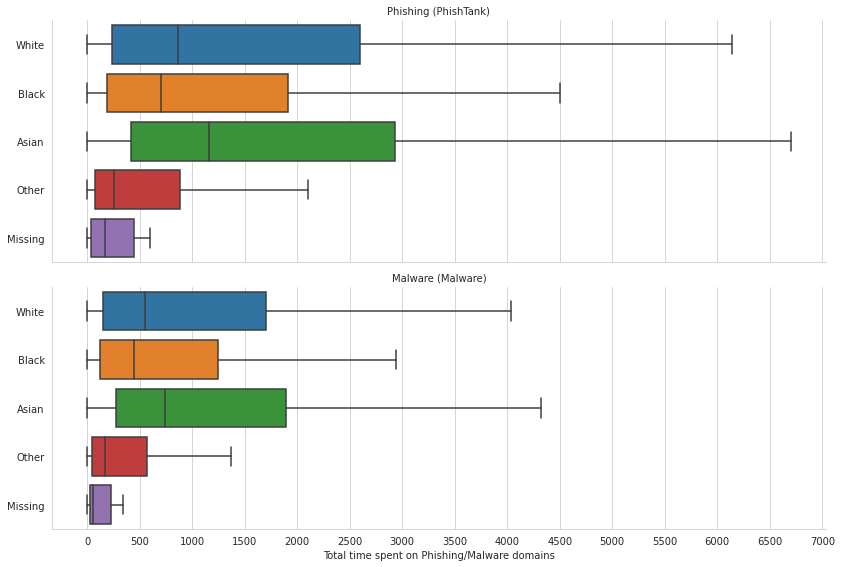

In [28]:
adf = pd.melt(mdf, id_vars=['racial_background'], value_vars=['total_time_phishing', 'total_time_malware'], var_name='model', value_name='total_time')
adf['model'] = adf['model'].replace({'total_time_phishing':'Phishing (PhishTank)', 'total_time_malware':'Malware (Malware)'})
g = sns.catplot(x="total_time", y="racial_background",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=race.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}');
g.set_ylabels('');
g.set_xlabels('Total time spent on Phishing/Malware domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_time_phishing_malware_race.eps', format='eps', dpi=300)

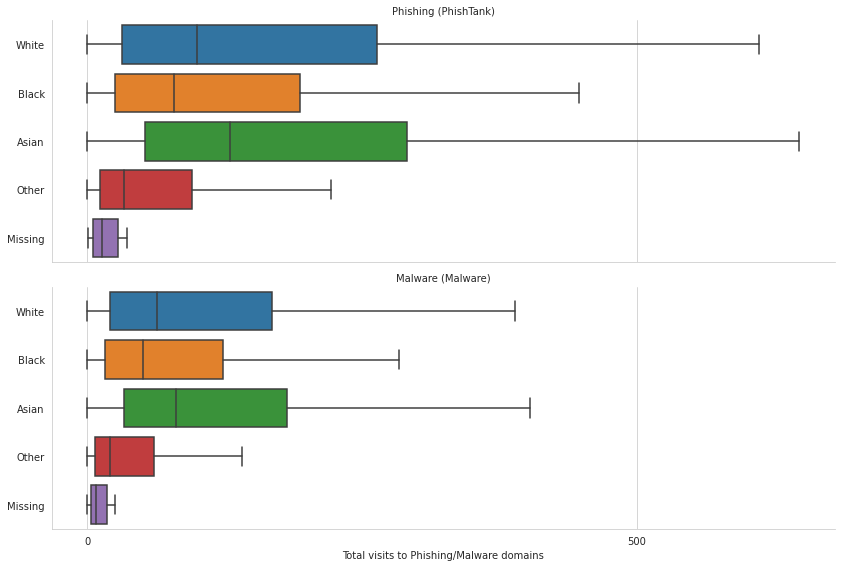

In [50]:
adf = pd.melt(mdf, id_vars=['racial_background'], value_vars=['total_visits_phishing', 'total_visits_malware'], var_name='model', value_name='total_visits')
adf['model'] = adf['model'].replace({'total_visits_phishing':'Phishing (PhishTank)', 'total_visits_malware':'Malware (Malware)'})
g = sns.catplot(x="total_visits", y="racial_background",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=race.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}');
g.set_ylabels('');
g.set_xlabels('Total visits to Phishing/Malware domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_visits_phishing_malware_race.eps', format='eps', dpi=300)

In [29]:
mdf.groupby(['racial_background'])['total_time_tl_malware', 'total_visits_tl_malware'].describe().astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_tl_malware                                     \
                                  count mean  std min 25%  50%  75%    max   
racial_background                                                            
Asian                              5769  328  765   0  51  135  341  28892   
Black                              9775  206  880   0  19   75  209  77749   
Missing                              10   16   14   0   6   11   26     44   
Other                             18553  135  824   0   8   28   95  98970   
White                             47300  313  764   0  28  101  316  53732   

                  total_visits_tl_malware                                 
                                    count mean std min 25% 50% 75%   max  
racial_background                                                         
Asian                                5769   22  34   0   5  12  28   853  
Black                                9775   14  27   0   2   7  18  1340  
Missing                                10    1   1   0   0   1   1     4  
Other                               18553    9  18   0   1   3   9   665  
White                               47300   19  27   0   3   9  24   956

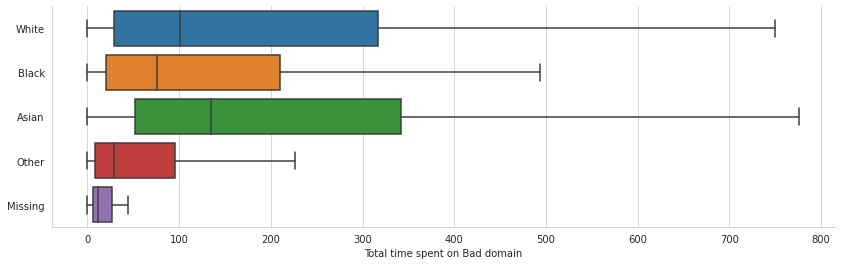

In [30]:
adf = pd.melt(mdf, id_vars=['racial_background'], value_vars=['total_time_tl_malware'], var_name='model', value_name='total_time')
g = sns.catplot(x="total_time", y="racial_background",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=race.values());
g.set_ylabels('');
g.set_titles('');
g.set_xlabels('Total time spent on Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(50))
    
g.savefig('./total_time_tl_malware_race.eps', format='eps', dpi=300)

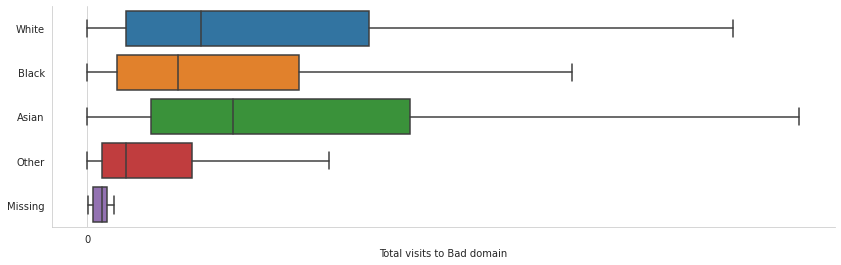

In [51]:
adf = pd.melt(mdf, id_vars=['racial_background'], value_vars=['total_visits_tl_malware'], var_name='model', value_name='total_visits')
g = sns.catplot(x="total_visits", y="racial_background",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=race.values());
g.set_ylabels('');
g.set_titles('');
g.set_xlabels('Total visits to Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(50))
    
g.savefig('./total_visits_tl_malware_race.eps', format='eps', dpi=300)

#### By Age

Next, we track things by age. Here we have a fairly consistent pattern. People 60 and over most frequently visit (spend the most time) on phishing and malware sites. People under 30 lie on the other end of the spectrum. People in thirties, forties, and fifies generally come in between.  

In [31]:
mdf.groupby(['hoh_oldest_age'])['total_time_phishing', 'total_visits_phishing'].describe().astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_phishing                                          \
                             count  mean   std min  25%  50%   75%     max   
hoh_oldest_age                                                               
18-20                         1560  1152  2815   0   95  344  1045   39345   
21-24                         2812  1516  4563   0  105  391  1280  125988   
25-29                         4958  1904  7047   0  130  484  1578  273833   
30-34                         5714  2131  6045   0  166  591  1846  135709   
35-39                         6820  2185  8303   0  188  646  1883  392928   
40-44                         7919  2283  8781   0  184  671  1992  455084   
45-49                        10900  2289  8598   0  143  617  1964  393303   
50-54                        12461  2068  5912   0   98  516  1888  178752   
55-59                         9201  2530  7315   0  200  789  2439  257024   
60-64                         6463  2918  7157   0  274  969  2956  188606   
65 and over                  12595  2882  7139   0  278  958  2829  338646   
Missing                          4   624  1035   5   36  161   749    2167   

               total_visits_phishing                                     
                               count mean  std min 25%  50%  75%    max  
hoh_oldest_age                                                           
18-20                           1560   94  152   0  15   42  118   3062  
21-24                           2812  113  202   0  15   47  129   4266  
25-29                           4958  135  221   0  18   56  156   3997  
30-34                           5714  154  242   0  22   69  181   4888  
35-39                           6820  156  265   0  24   74  189   7858  
40-44                           7919  166  268   0  24   76  202   6503  
45-49                          10900  166  285   0  21   71  201   9378  
50-54                          12461  164  419   0  14   61  195  27517  
55-59                           9201  199  321   0  26   89  245  10813  
60-64                           6463  245  515   0  37  115  308  30493  
65 and over                    12595  241  429   0  37  114  304  26028  
Missing                            4   45   57   2   7   24   62    127

In [32]:
mdf.groupby(['hoh_oldest_age'])['total_time_malware', 'total_visits_malware'].describe().astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_malware                                          \
                            count  mean   std min  25%  50%   75%     max   
hoh_oldest_age                                                              
18-20                        1560   759  1822   0   64  222   656   26580   
21-24                        2812   989  3003   0   64  255   835   90187   
25-29                        4958  1269  5746   0   85  309   996  273694   
30-34                        5714  1471  5292   0  106  383  1180  165681   
35-39                        6820  1489  7101   0  123  413  1237  392112   
40-44                        7919  1598  7792   0  117  427  1323  434907   
45-49                       10900  1612  7210   0   93  397  1279  390354   
50-54                       12461  1412  4697   0   63  332  1215  196356   
55-59                        9201  1757  6086   0  127  503  1576  241482   
60-64                        6463  2004  5689   0  176  625  1997  186895   
65 and over                 12595  1989  5061   0  180  616  1902  189046   
Missing                         4   315   512   4   23   89   381    1077   

               total_visits_malware                                    
                              count mean  std min 25% 50%  75%    max  
hoh_oldest_age                                                         
18-20                          1560   60   97   0   9  26   71   1855  
21-24                          2812   72  131   0   9  30   80   2870  
25-29                          4958   85  139   0  11  36   98   2739  
30-34                          5714   97  151   0  14  43  115   3016  
35-39                          6820   98  165   0  15  47  119   4763  
40-44                          7919  106  173   0  15  48  127   4405  
45-49                         10900  106  185   0  13  45  128   6076  
50-54                         12461  104  264   0   9  39  124  16693  
55-59                          9201  127  203   0  17  56  158   6590  
60-64                          6463  156  319   0  23  73  197  18297  
65 and over                   12595  154  276   0  23  73  195  16532  
Missing                           4   26   34   1   5  14   35     76

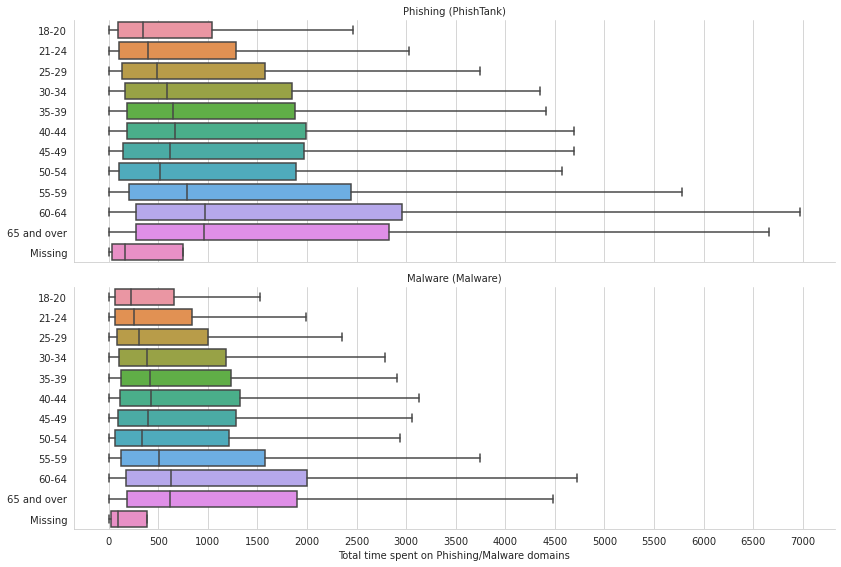

In [33]:
adf = pd.melt(mdf, id_vars=['hoh_oldest_age'], value_vars=['total_time_phishing', 'total_time_malware'], var_name='model', value_name='total_time')
adf['model'] = adf['model'].replace({'total_time_phishing':'Phishing (PhishTank)', 'total_time_malware':'Malware (Malware)'})

g = sns.catplot(x="total_time", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total time spent on Phishing/Malware domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_time_phishing_malware_age.eps', format='eps', dpi=300)

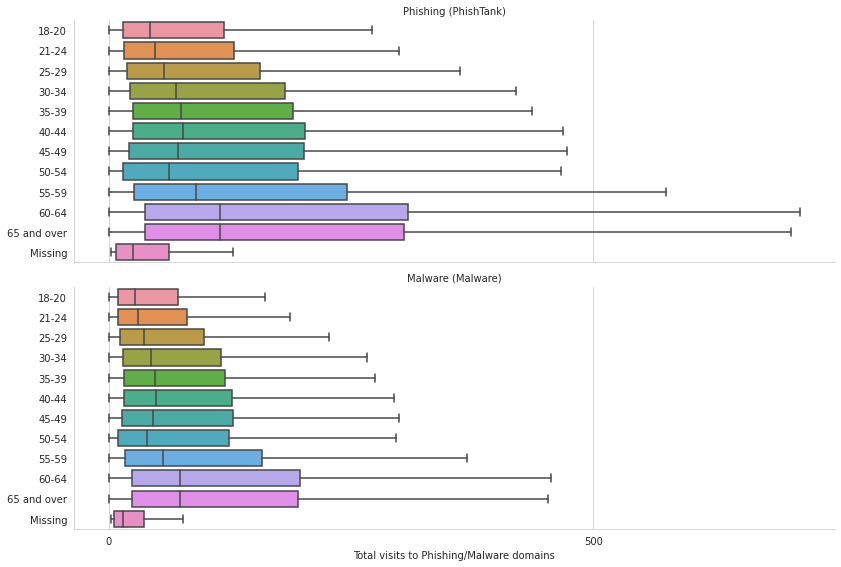

In [52]:
adf = pd.melt(mdf, id_vars=['hoh_oldest_age'], value_vars=['total_visits_phishing', 'total_visits_malware'], var_name='model', value_name='total_visits')
adf['model'] = adf['model'].replace({'total_visits_phishing':'Phishing (PhishTank)', 'total_visits_malware':'Malware (Malware)'})

g = sns.catplot(x="total_visits", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total visits to Phishing/Malware domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_visits_phishing_malware_age.eps', format='eps', dpi=300)

In [34]:
mdf.groupby(['hoh_oldest_age'])['total_time_tl_malware', 'total_visits_tl_malware'].describe(percentiles = [.25, .50, .75, .85]).astype(int)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


total_time_tl_malware                                           \
                               count mean   std min 25%  50%  75%  85%    max   
hoh_oldest_age                                                                  
18-20                           1560  130   310   0  12   38  115  207   6742   
21-24                           2812  166   654   0  12   45  144  254  28892   
25-29                           4958  193   491   0  15   55  170  308  12048   
30-34                           5714  240  1154   0  19   66  205  382  77749   
35-39                           6820  236  1298   0  22   72  219  381  98970   
40-44                           7919  240   588   0  20   75  229  398  16357   
45-49                          10900  241   613   0  16   69  227  410  22722   
50-54                          12461  238   867   0  11   59  216  402  53732   
55-59                           9201  286   710   0  22   89  290  511  37851   
60-64                           6463  341   714   0  32  116  371  628  19090   
65 and over                    12595  339   670   0  33  114  358  630  15011   
Missing                            4   69   106   1   1   25   93  146    226   

               total_visits_tl_malware                                     
                                 count mean std min 25% 50% 75% 85%   max  
hoh_oldest_age                                                             
18-20                             1560    8  12   0   1   4  10  16   135  
21-24                             2812   10  17   0   1   5  12  20   283  
25-29                             4958   12  20   0   2   5  14  23   349  
30-34                             5714   14  21   0   2   6  17  27   371  
35-39                             6820   14  20   0   2   7  18  27   347  
40-44                             7919   15  22   0   2   7  18  28   459  
45-49                            10900   15  24   0   2   7  19  29   679  
50-54                            12461   14  27   0   1   6  18  29  1202  
55-59                             9201   18  26   0   2   8  23  35   461  
60-64                             6463   22  35   0   3  11  29  42  1340  
65 and over                      12595   21  32   0   3  11  28  42   956  
Missing                              4    5   6   0   0   2   7  10    14

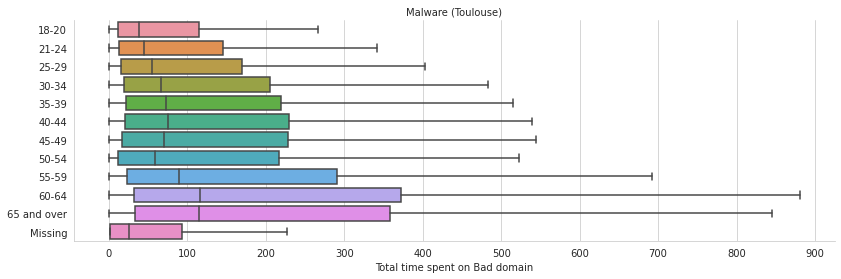

In [35]:
adf = pd.melt(mdf, id_vars=['hoh_oldest_age'], value_vars=['total_time_tl_malware'], var_name='model', value_name='total_time')
g = sns.catplot(x="total_time", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_ylabels('');
g.set_titles('Malware (Toulouse)');
g.set_xlabels('Total time spent on Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(50))
    
g.savefig('./total_time_tl_malware_age.eps', format='eps', dpi=300)

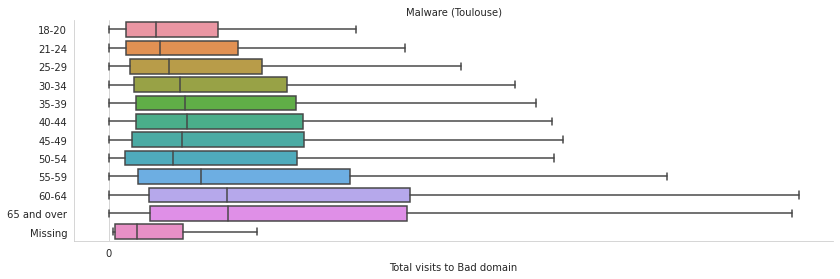

In [53]:
adf = pd.melt(mdf, id_vars=['hoh_oldest_age'], value_vars=['total_visits_tl_malware'], var_name='model', value_name='total_visits')
g = sns.catplot(x="total_visits", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_ylabels('');
g.set_titles('Malware (Toulouse)');
g.set_xlabels('Total visits to Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(50))
    
g.savefig('./total_visits_tl_malware_age.eps', format='eps', dpi=300)

### Proportion of time, visits

We think some of the patterns we see are a reflection of the total time people spend online. And exposure to problems may be greater just as a result of that. And that is an important insight. We also believe though that the more educated, more instance, are less likely---adjusted for frequency---to go to phishing and malware sites because they have greater skills. So we now look at proportions. The data are roughly in line with expectations for education with the least educated (remember this is household level) spending the largest share of their time (visits) on phishing and malware sites and the most educated spending the least. For race as well the pattern is flipped. For age, we don't expect such a pattern and that is indeed what we find.

In [36]:
mdf['prop_phishing_visits'] = mdf['total_visits_phishing']/mdf['total_visits']
mdf['prop_phishing_time'] = mdf['total_time_phishing']/mdf['total_time']

mdf['prop_malware_visits'] = mdf['total_visits_malware']/mdf['total_visits']
mdf['prop_malware_time']   = mdf['total_time_malware']/mdf['total_time']

mdf['prop_tl_malware_visits'] = mdf['total_visits_tl_malware']/mdf['total_visits']
mdf['prop_tl_malware_time']   = mdf['total_time_tl_malware']/mdf['total_time']

In [37]:
grp_prop_visits = ['prop_phishing_visits', 'prop_malware_visits', 'prop_tl_malware_visits']
grp_prop_time = ['prop_phishing_time', 'prop_malware_time', 'prop_tl_malware_time']

In [38]:
mdf.groupby(['hoh_most_education'])['prop_phishing_visits', 'prop_phishing_time',
                                    'prop_malware_visits', 'prop_malware_time',
                                    'prop_tl_malware_visits', 'prop_tl_malware_time'].mean().round(3)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,prop_phishing_visits,prop_phishing_time,prop_malware_visits,prop_malware_time,prop_tl_malware_visits,prop_tl_malware_time
hoh_most_education,,,,,,
Associate degree,0.177,0.152,0.113,0.101,0.018,0.018
Bachelor’s degree,0.176,0.149,0.112,0.098,0.018,0.018
Graduate degree,0.176,0.140,0.111,0.092,0.018,0.018
High school diploma or equivalent,0.174,0.153,0.113,0.105,0.018,0.018
Missing,0.177,0.159,0.117,0.110,0.019,0.019
Some college but no degree,0.178,0.154,0.115,0.105,0.018,0.018


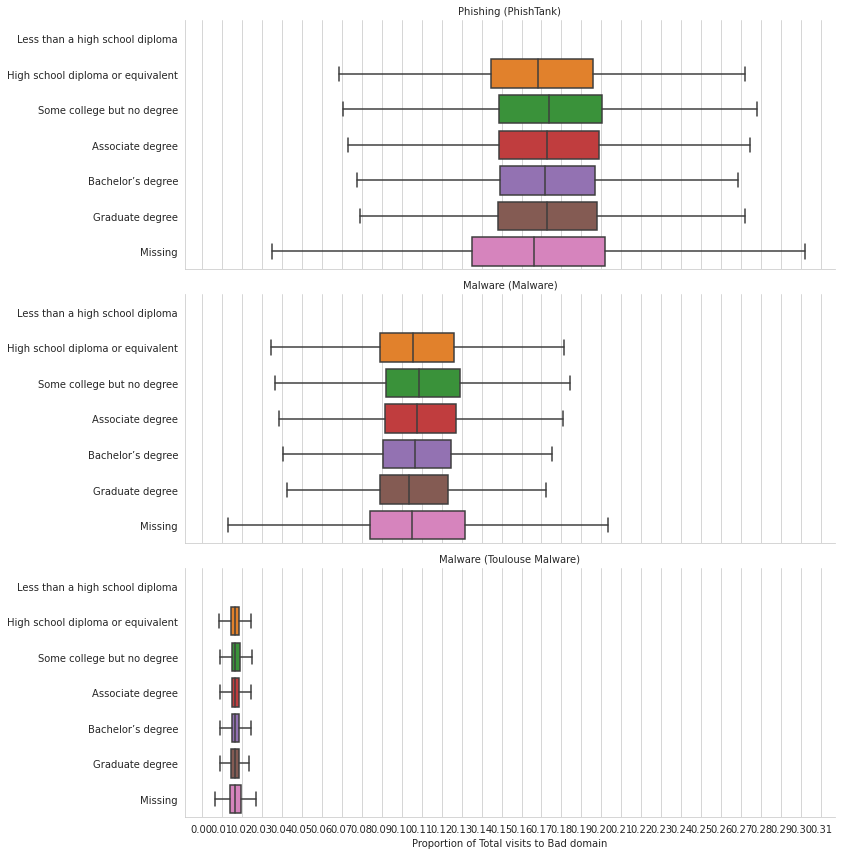

In [39]:
adf = pd.melt(mdf, id_vars=['hoh_most_education'], value_vars=grp_prop_visits, var_name='model', value_name='prop_total_visits')

adf['model'] = adf['model'].replace({'prop_phishing_visits':'Phishing (PhishTank)', 'prop_malware_visits':'Malware (Malware)', 'prop_tl_malware_visits':'Malware (Toulouse Malware)'})

g = sns.catplot(x="prop_total_visits", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of Total visits to Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.01))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.05))

g.savefig('./prop_total_visits_phishing_malware_tl_educ.eps', format='eps', dpi=300)

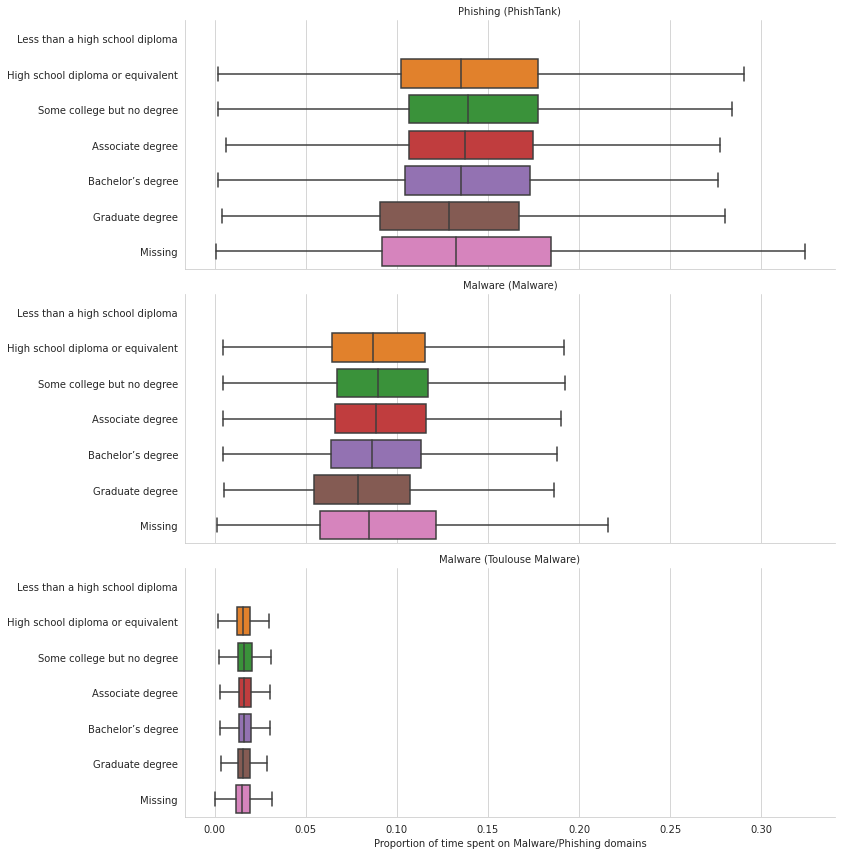

In [40]:
adf = pd.melt(mdf, id_vars=['hoh_most_education'], value_vars=grp_prop_time, var_name='model', value_name='prop_total_time')
adf['model'] = adf['model'].replace({'prop_phishing_time':'Phishing (PhishTank)', 'prop_malware_time':'Malware (Malware)', 'prop_tl_malware_time':'Malware (Toulouse Malware)'})

g = sns.catplot(x="prop_total_time", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of time spent on Malware/Phishing domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.01))

g.savefig('./prop_total_time_phishing_malware_tl_educ.eps', format='eps', dpi=300)    

In [41]:
mdf.groupby(['racial_background'])['prop_phishing_visits', 'prop_phishing_time',
                                   'prop_malware_visits', 'prop_malware_time',
                                   'prop_tl_malware_visits', 'prop_tl_malware_time'].mean().round(3)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,prop_phishing_visits,prop_phishing_time,prop_malware_visits,prop_malware_time,prop_tl_malware_visits,prop_tl_malware_time
racial_background,,,,,,
Asian,0.170,0.144,0.109,0.094,0.018,0.017
Black,0.182,0.163,0.119,0.111,0.019,0.019
Missing,0.188,0.199,0.111,0.114,0.017,0.014
Other,0.174,0.155,0.114,0.106,0.018,0.018
White,0.178,0.154,0.115,0.104,0.018,0.019


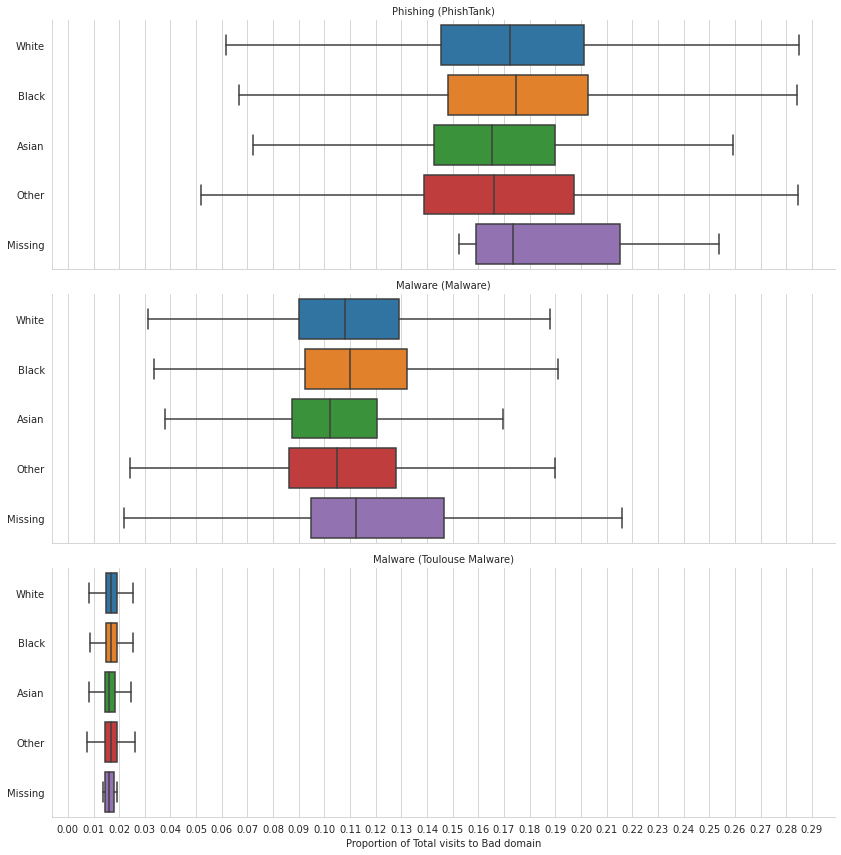

In [42]:
adf = pd.melt(mdf, id_vars=['racial_background'], value_vars=grp_prop_visits, var_name='model', value_name='prop_total_visits')
adf['model'] = adf['model'].replace({'prop_phishing_visits':'Phishing (PhishTank)', 'prop_malware_visits':'Malware (Malware)', 'prop_tl_malware_visits':'Malware (Toulouse Malware)'})
g = sns.catplot(x="prop_total_visits", y="racial_background",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=race.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of Total visits to Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.01))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.001))

g.savefig('./prop_total_visits_phishing_malware_tl_race.eps', format='eps', dpi=300)

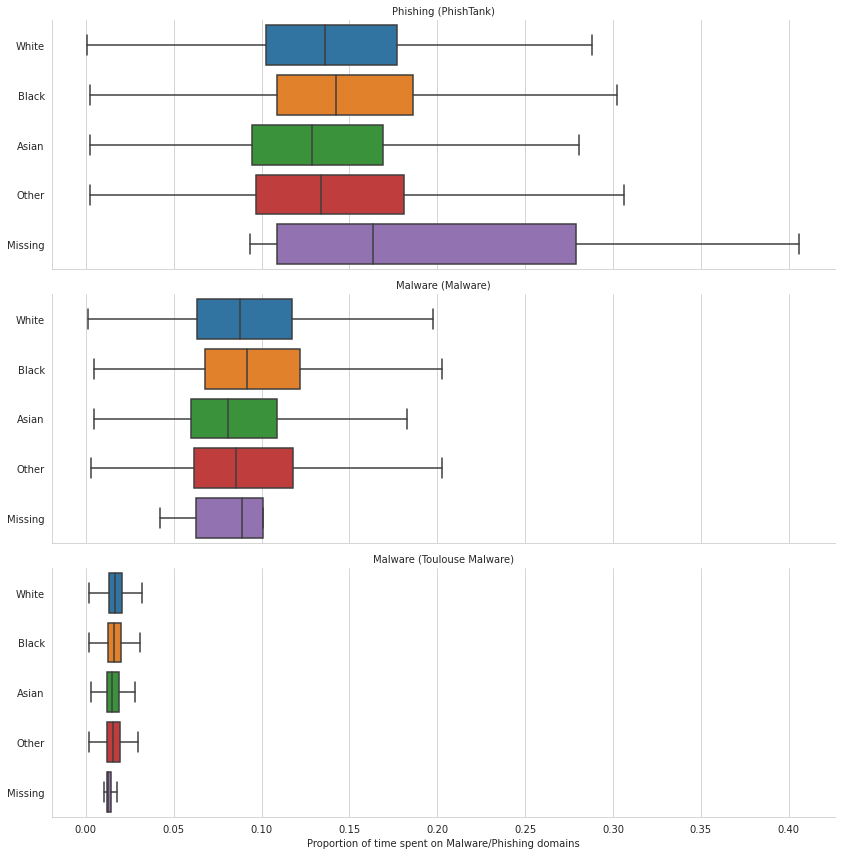

In [43]:
adf = pd.melt(mdf, id_vars=['racial_background'], value_vars=grp_prop_time, var_name='model', value_name='prop_total_time')
adf['model'] = adf['model'].replace({'prop_phishing_time':'Phishing (PhishTank)', 'prop_malware_time':'Malware (Malware)', 'prop_tl_malware_time':'Malware (Toulouse Malware)'})
g = sns.catplot(x="prop_total_time", y="racial_background",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=race.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of time spent on Malware/Phishing domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.01))

g.savefig('./prop_total_time_phishing_malware_tl_race.eps', format='eps', dpi=300)

Given plausible skew in total visits and time spent, we also check how medians look across income, education, and race

In [44]:
mdf.groupby(['hoh_oldest_age'])['prop_phishing_visits', 'prop_phishing_time',
                                'prop_malware_visits', 'prop_malware_time',
                                'prop_tl_malware_visits', 'prop_tl_malware_time'].mean().round(3)

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,prop_phishing_visits,prop_phishing_time,prop_malware_visits,prop_malware_time,prop_tl_malware_visits,prop_tl_malware_time
hoh_oldest_age,,,,,,
18-20,0.166,0.140,0.109,0.095,0.017,0.017
21-24,0.168,0.145,0.108,0.097,0.018,0.017
25-29,0.171,0.149,0.111,0.100,0.018,0.017
30-34,0.175,0.155,0.113,0.104,0.018,0.018
35-39,0.174,0.151,0.112,0.102,0.018,0.018
40-44,0.175,0.154,0.113,0.104,0.018,0.018
45-49,0.178,0.155,0.115,0.105,0.018,0.018
50-54,0.179,0.159,0.117,0.109,0.019,0.020
55-59,0.179,0.158,0.116,0.107,0.018,0.019


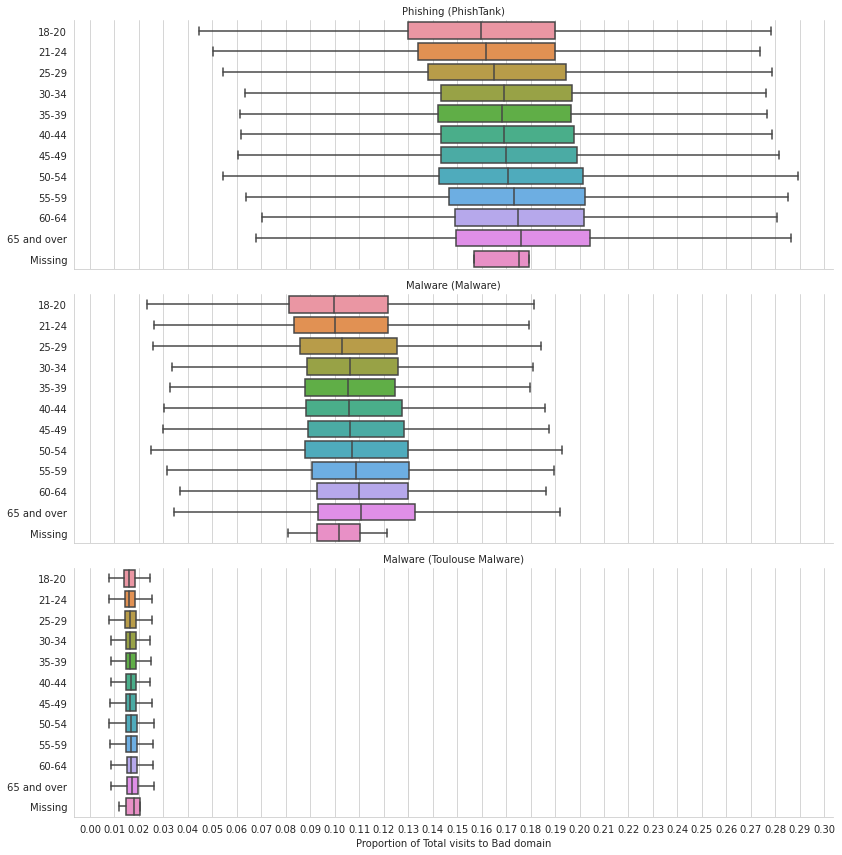

In [45]:
adf = pd.melt(mdf, id_vars=['hoh_oldest_age'], value_vars=grp_prop_visits, var_name='model', value_name='prop_total_visits')
adf['model'] = adf['model'].replace({'prop_phishing_visits':'Phishing (PhishTank)', 'prop_malware_visits':'Malware (Malware)', 'prop_tl_malware_visits':'Malware (Toulouse Malware)'})
g = sns.catplot(x="prop_total_visits", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of Total visits to Bad domain')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.01))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.001))

g.savefig('./prop_total_visits_phishing_malware_tl_age.eps', format='eps', dpi=300)

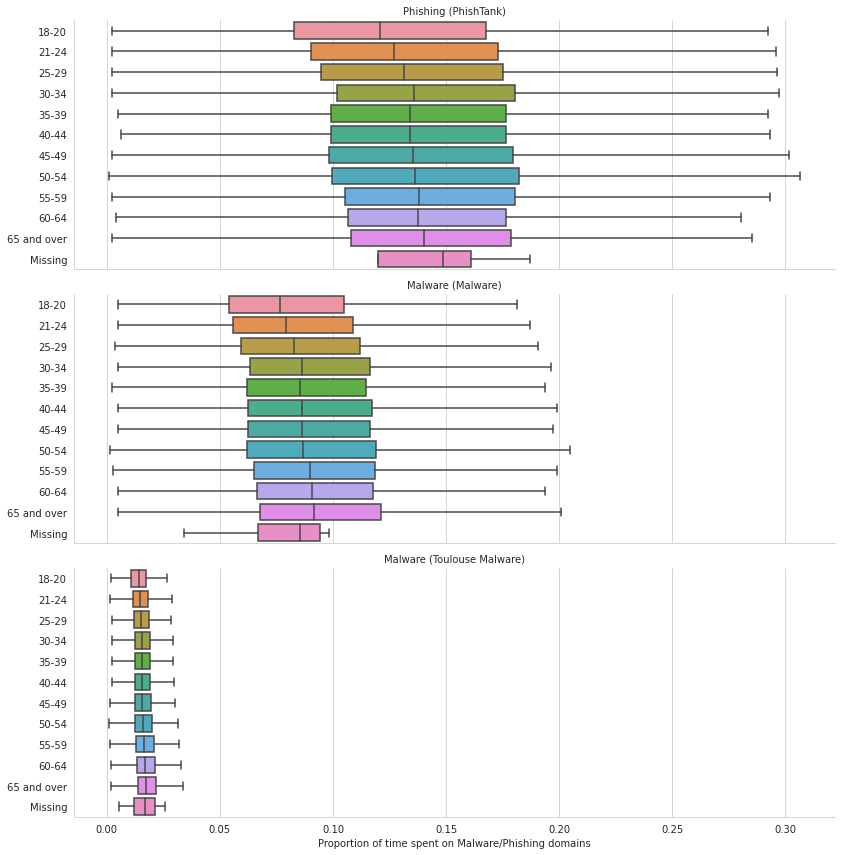

In [46]:
adf = pd.melt(mdf, id_vars=['hoh_oldest_age'], value_vars=grp_prop_time, var_name='model', value_name='prop_total_time')
adf['model'] = adf['model'].replace({'prop_phishing_time':'Phishing (PhishTank)', 'prop_malware_time':'Malware (Malware)', 'prop_tl_malware_time':'Malware (Toulouse Malware)'})
g = sns.catplot(x="prop_total_time", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of time spent on Malware/Phishing domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.01))

g.savefig('./prop_total_time_phishing_malware_tl_age.eps', format='eps', dpi=300)